# Trained Vector Cloud: Eigenvector Cross-Sections (Euclidean Space)

**Goal:** Visualize the extent of the *trained* embedding matrix when projected onto the trained eigenbasis, but measured in **Euclidean distance** (not causal distance).

**Key question:** How much of the anisotropy we see in 09.3b comes from the *raw vector distribution* vs. the *metric transformation*?

## The Missing Link

We now have:
- **09.5a:** Initialized vectors in Euclidean space → fuzzy cylinder (CV ≈ 4.3%)
- **09.3b:** Trained vectors in causal space → strong anisotropy (CV ≈ 38.4%)
- **09.5b (THIS NOTEBOOK):** Trained vectors in Euclidean space → ???

## What This Tells Us

**If CV is LOW (~5-10%):**
- The trained vectors themselves are still roughly isotropic (like initialized vectors)
- The 38% anisotropy in 09.3b comes from the *metric* revealing hidden correlations
- Training organized vectors subtly; metric amplifies the structure

**If CV is HIGH (~30-40%):**
- The trained vectors themselves are strongly anisotropic
- Training literally moved vectors into asymmetric positions in Euclidean space
- The metric just measures this already-obvious structure

**Method:**
1. Load trained lm_head embedding matrix (γ)
2. Project onto trained eigenbasis (same basis as 09.3b and 09.5a)
3. Compute cross-sectional extent WITHOUT eigenvalue scaling (Euclidean distance)
4. Compare to both 09.5a (initialized) and 09.3b (causal)

## Configuration

In [4]:
# Data paths
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Model to load
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

# Special eigenvectors to highlight (same as 09.3b and 09.5a for comparison)
SPECIAL_RANKS = {
    0: "Rank 0 (smallest λ)",
    2557: "Rank 2557 (4th largest λ)",
    2558: "Rank 2558 (3rd largest λ)",
    2559: "Rank 2559 (largest λ)"
}

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Special eigenvectors: {list(SPECIAL_RANKS.keys())}")

Configuration:
  Model: Qwen/Qwen3-4B-Instruct-2507
  Special eigenvectors: [0, 2557, 2558, 2559]


## Setup

In [5]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [6]:
print("Loading trained model data...\\n")

# Load model
print(f"Loading model from {MODEL_NAME}...")
print("  This will take a minute...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map='cpu',
)

# Extract unembedding matrix (gamma)
print("\\nExtracting lm_head embeddings (gamma)...")
gamma = model.lm_head.weight.data.to(torch.float32).cpu()  # [vocab_size, hidden_dim]

# Load eigenbasis
print(f"\\nLoading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvectors = eigenbasis_data['eigenvectors']  # [hidden_dim, hidden_dim]
eigenvalues = eigenbasis_data['eigenvalues']    # [hidden_dim]

vocab_size, hidden_dim = gamma.shape

print(f"\\n✓ Data loaded")
print(f"  Gamma shape: {gamma.shape}")
print(f"  Eigenvectors shape: {eigenvectors.shape}")
print(f"  Eigenvalues shape: {eigenvalues.shape}")

# Compute Euclidean norms of trained vectors
norms_trained = torch.norm(gamma, dim=1)
print(f"\\nEuclidean norms of trained vectors:")
print(f"  Mean: {norms_trained.mean():.4f}")
print(f"  Std: {norms_trained.std():.4f}")
print(f"  Range: [{norms_trained.min():.4f}, {norms_trained.max():.4f}]")
print(f"  CV: {(norms_trained.std() / norms_trained.mean() * 100):.2f}%")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading trained model data...\n
Loading model from Qwen/Qwen3-4B-Instruct-2507...
  This will take a minute...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

\nExtracting lm_head embeddings (gamma)...
\nLoading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
\n✓ Data loaded
  Gamma shape: torch.Size([151936, 2560])
  Eigenvectors shape: torch.Size([2560, 2560])
  Eigenvalues shape: torch.Size([2560])
\nEuclidean norms of trained vectors:
  Mean: 1.0873
  Std: 0.1681
  Range: [0.3595, 1.6050]
  CV: 15.46%


## Project Onto Eigenbasis

In [7]:
print("\nProjecting trained vectors onto eigenbasis...")

# Project: gamma @ eigenvectors
# gamma: [vocab_size, hidden_dim]
# eigenvectors: [hidden_dim, hidden_dim]
# Result: [vocab_size, hidden_dim]

projections_trained = gamma @ eigenvectors

print(f"\n✓ Projections computed")
print(f"  Shape: {projections_trained.shape}")
print(f"  Mean: {projections_trained.mean():.6f}")
print(f"  Std: {projections_trained.std():.6f}")


Projecting trained vectors onto eigenbasis...

✓ Projections computed
  Shape: torch.Size([151936, 2560])
  Mean: 0.000094
  Std: 0.021745


## Compute Cloud Extent Along Each Eigenvector (Euclidean Distance)

In [8]:
print("\n" + "=" * 80)
print("COMPUTING CLOUD EXTENT ALONG ALL EIGENVECTORS (EUCLIDEAN DISTANCE)")
print("=" * 80)

print(f"\nComputing extent for each of {hidden_dim:,} eigenvectors...")

# Convert to numpy
projections_np = projections_trained.numpy()

# Compute max/min extent along each eigenvector (in EUCLIDEAN distance units)
# NOTE: NO eigenvalue scaling - this is pure Euclidean geometry
# Compare to 09.3b which scales by sqrt(eigenvalue) for causal distance

max_extent = np.zeros(hidden_dim)
min_extent = np.zeros(hidden_dim)
diameters = np.zeros(hidden_dim)

for i in range(hidden_dim):
    # Projections in eigenbasis coordinates (Euclidean, no scaling)
    proj_i = projections_np[:, i]
    
    # Max and min extents
    max_extent[i] = proj_i.max()
    min_extent[i] = proj_i.min()
    diameters[i] = max_extent[i] - min_extent[i]

print(f"✓ Extents computed (in Euclidean distance units)\n")

# Summary statistics
print(f"Diameter statistics (Euclidean units):")
print(f"  Min: {diameters.min():.4f}")
print(f"  Max: {diameters.max():.4f}")
print(f"  Mean: {diameters.mean():.4f}")
print(f"  Median: {np.median(diameters):.4f}")
print(f"  Std: {diameters.std():.4f}")
print(f"  CV: {(diameters.std() / diameters.mean() * 100):.2f}%")

print(f"\n**KEY COMPARISON:**")
print(f"  09.5a (Initialized, Euclidean): CV ≈ 4.3%")
print(f"  09.5b (Trained, Euclidean):     CV = {(diameters.std() / diameters.mean() * 100):.2f}%  ← THIS")
print(f"  09.3b (Trained, Causal):        CV ≈ 38.4%")

print(f"\nMax extent statistics:")
print(f"  Range: [{max_extent.min():.4f}, {max_extent.max():.4f}]")
print(f"  Mean: {max_extent.mean():.4f}")

print(f"\nMin extent statistics:")
print(f"  Range: [{min_extent.min():.4f}, {min_extent.max():.4f}]")
print(f"  Mean: {min_extent.mean():.4f}")


COMPUTING CLOUD EXTENT ALONG ALL EIGENVECTORS (EUCLIDEAN DISTANCE)

Computing extent for each of 2,560 eigenvectors...
✓ Extents computed (in Euclidean distance units)

Diameter statistics (Euclidean units):
  Min: 0.0650
  Max: 1.5307
  Mean: 0.2183
  Median: 0.2061
  Std: 0.0542
  CV: 24.81%

**KEY COMPARISON:**
  09.5a (Initialized, Euclidean): CV ≈ 4.3%
  09.5b (Trained, Euclidean):     CV = 24.81%  ← THIS
  09.3b (Trained, Causal):        CV ≈ 38.4%

Max extent statistics:
  Range: [-0.0188, 0.7260]
  Mean: 0.1092

Min extent statistics:
  Range: [-0.8047, -0.0306]
  Mean: -0.1091


## Special Eigenvectors: Detailed View

In [9]:
print("\n" + "=" * 80)
print("SPECIAL EIGENVECTORS: EXTENT ANALYSIS")
print("=" * 80)

mean_diameter = diameters.mean()

print(f"\n{'Rank':<6} {'Eigenvalue':<15} {'Min':<10} {'Max':<10} {'Diameter':<12} {'vs. Mean':<12} {'Description'}")
print("=" * 100)

for rank in sorted(SPECIAL_RANKS.keys()):
    eigenval = eigenvalues[rank].item()
    min_ext = min_extent[rank]
    max_ext = max_extent[rank]
    diameter = diameters[rank]
    deviation = diameter - mean_diameter
    percent = (deviation / mean_diameter) * 100
    
    print(f"{rank:<6} {eigenval:>14,.0f} {min_ext:>9.4f} {max_ext:>9.4f} {diameter:>11.4f} {deviation:>+10.4f} ({percent:>+5.1f}%)  {SPECIAL_RANKS[rank]}")

print(f"\nMean diameter: {mean_diameter:.4f} Euclidean units")


SPECIAL EIGENVECTORS: EXTENT ANALYSIS

Rank   Eigenvalue      Min        Max        Diameter     vs. Mean     Description
0                  95   -0.8047    0.7260      1.5307    +1.3124 (+601.1%)  Rank 0 (smallest λ)
2557           24,434   -0.0987    0.0516      0.1503    -0.0680 (-31.1%)  Rank 2557 (4th largest λ)
2558           73,918   -0.0306    0.0344      0.0650    -0.1533 (-70.2%)  Rank 2558 (3rd largest λ)
2559           94,218   -0.1054   -0.0188      0.0866    -0.1318 (-60.4%)  Rank 2559 (largest λ)

Mean diameter: 0.2183 Euclidean units


## Cross-Sectional Envelope Plot


CREATING CROSS-SECTIONAL ENVELOPE PLOT


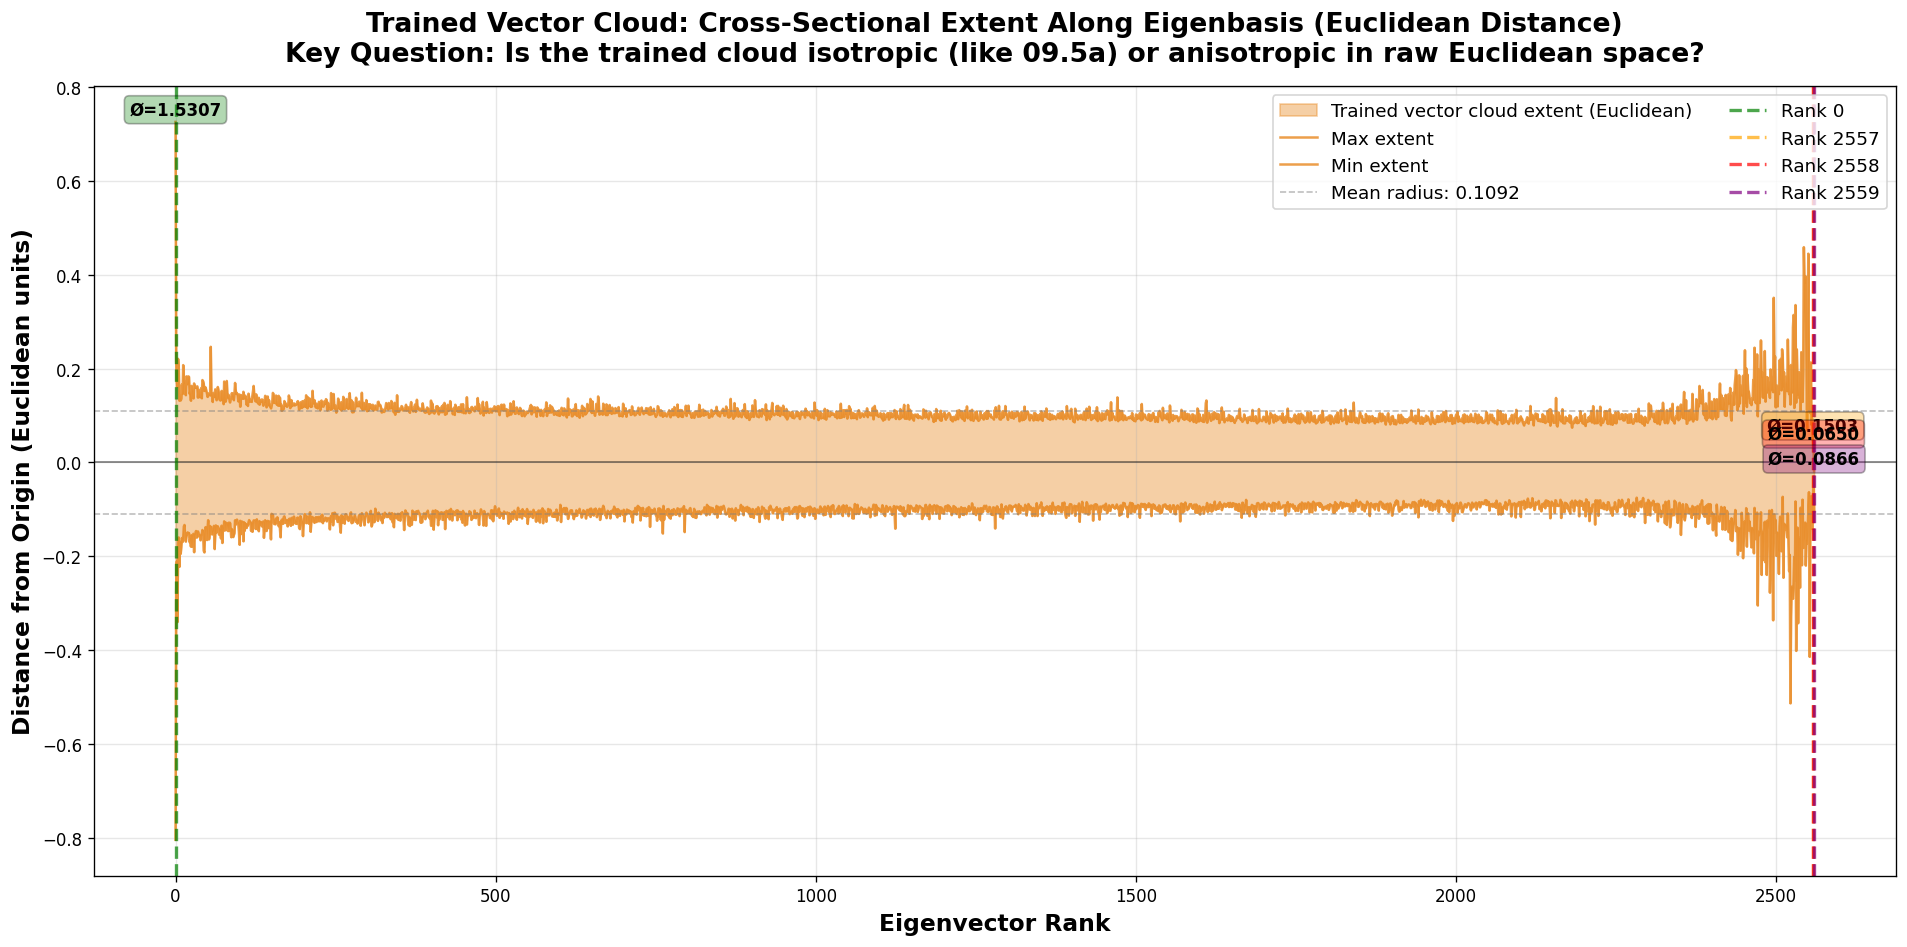


✓ Cross-sectional envelope plot created


In [10]:
print("\n" + "=" * 80)
print("CREATING CROSS-SECTIONAL ENVELOPE PLOT")
print("=" * 80)

# X-axis: eigenvector ranks
ranks = np.arange(hidden_dim)

# Create figure
fig, ax = plt.subplots(figsize=(16, 8), dpi=120)

# Plot envelope (shaded area between min and max)
ax.fill_between(ranks, min_extent, max_extent, 
                alpha=0.4, color='#E8871E', label='Trained vector cloud extent (Euclidean)')

# Plot upper and lower bounds
ax.plot(ranks, max_extent, linewidth=1.5, color='#E8871E', alpha=0.8, label='Max extent')
ax.plot(ranks, min_extent, linewidth=1.5, color='#E8871E', alpha=0.8, label='Min extent')

# Add zero line (origin)
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Add mean diameter line for reference
ax.axhline(mean_diameter/2, color='gray', linestyle='--', linewidth=1, alpha=0.5,
           label=f'Mean radius: {mean_diameter/2:.4f}')
ax.axhline(-mean_diameter/2, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Highlight special eigenvectors
colors = {0: 'green', 2557: 'orange', 2558: 'red', 2559: 'purple'}
for rank in SPECIAL_RANKS.keys():
    ax.axvline(rank, color=colors[rank], linestyle='--', linewidth=2, alpha=0.7,
               label=f'Rank {rank}')

# Configure plot
ax.set_xlabel('Eigenvector Rank', fontsize=14, fontweight='bold')
ax.set_ylabel('Distance from Origin (Euclidean units)', fontsize=14, fontweight='bold')
ax.set_title('Trained Vector Cloud: Cross-Sectional Extent Along Eigenbasis (Euclidean Distance)\nKey Question: Is the trained cloud isotropic (like 09.5a) or anisotropic in raw Euclidean space?',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotations for special ranks
for rank in SPECIAL_RANKS.keys():
    diameter = diameters[rank]
    y_pos = max_extent[rank] + 0.01 * (max_extent.max() - min_extent.min())
    ax.text(rank, y_pos, f'Ø={diameter:.4f}', 
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[rank], alpha=0.3))

plt.tight_layout()
plt.show()

print("\n✓ Cross-sectional envelope plot created")

## Diameter Distribution Histogram


Creating diameter distribution histogram...


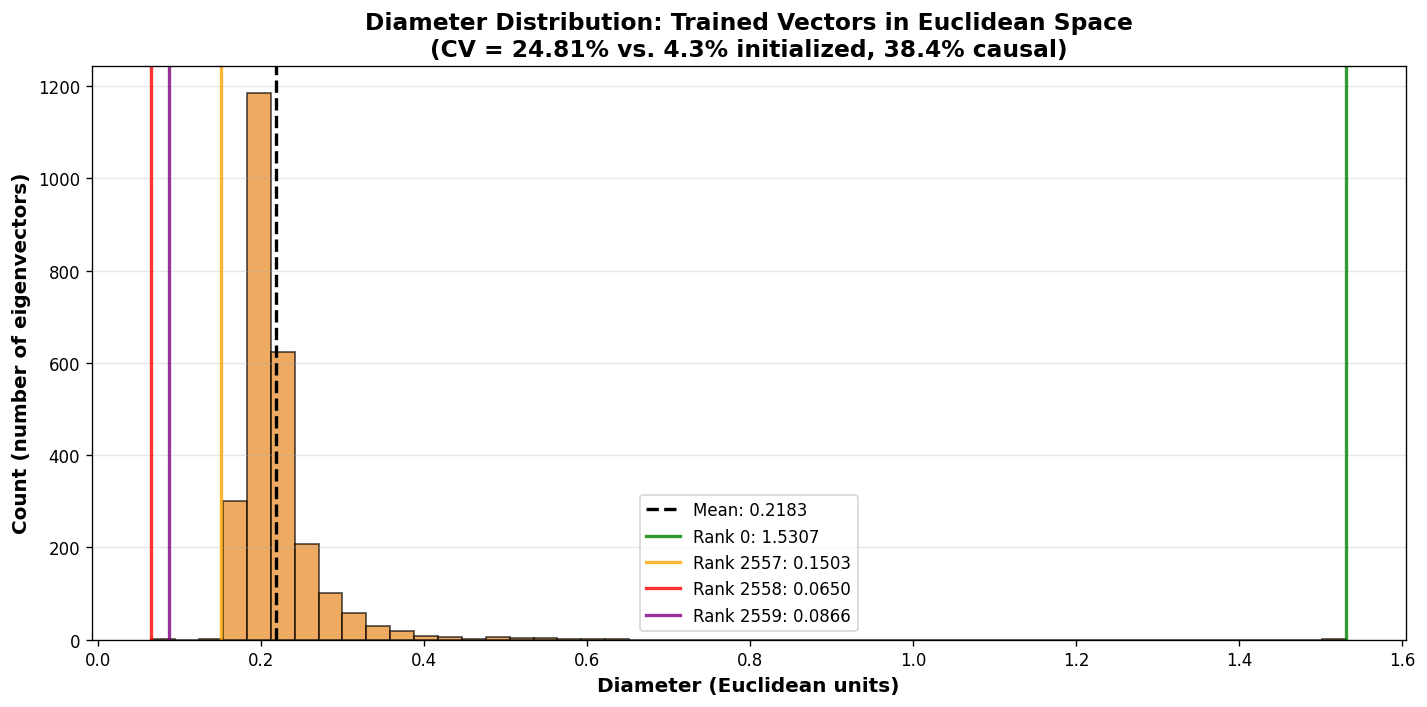

✓ Histogram created


In [11]:
print("\nCreating diameter distribution histogram...")

fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Histogram
counts, bins, patches = ax.hist(diameters, bins=50, color='#E8871E', alpha=0.7, edgecolor='black')

# Mark mean
ax.axvline(mean_diameter, color='black', linestyle='--', linewidth=2,
           label=f'Mean: {mean_diameter:.4f}')

# Mark special eigenvectors
for rank in SPECIAL_RANKS.keys():
    diameter = diameters[rank]
    ax.axvline(diameter, color=colors[rank], linestyle='-', linewidth=2,
               label=f'Rank {rank}: {diameter:.4f}', alpha=0.8)

ax.set_xlabel('Diameter (Euclidean units)', fontsize=12, fontweight='bold')
ax.set_ylabel('Count (number of eigenvectors)', fontsize=12, fontweight='bold')
ax.set_title(f'Diameter Distribution: Trained Vectors in Euclidean Space\n(CV = {(diameters.std() / diameters.mean() * 100):.2f}% vs. 4.3% initialized, 38.4% causal)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Histogram created")

## Summary & Interpretation

**What we measured:** The extent of the *trained* embedding matrix along eigenbasis directions, measured in **Euclidean distance** (no metric transformation).

**The Three-Way Comparison:**
1. **09.5a - Initialized vectors, Euclidean space:** CV ≈ 4.3% (noise floor)
2. **09.5b - Trained vectors, Euclidean space:** CV = ??? (THIS NOTEBOOK)
3. **09.3b - Trained vectors, Causal space:** CV ≈ 38.4% (strong anisotropy)

**Interpretation depends on the CV we observe:**

### Scenario A: CV is LOW (~5-10%)
**Meaning:** The trained vectors are still roughly isotropic in raw Euclidean space.

**Implication:** The 38% anisotropy in causal space comes from the *metric revealing hidden structure*. The covariance matrix captures subtle correlations between dimensions that aren't obvious in raw Euclidean coordinates. The causal metric "undoes" these correlations and reveals the true geometric organization.

**Analogy:** Like looking at a crystal through polarized light - the structure was always there, but the right measurement reveals it.

### Scenario B: CV is HIGH (~30-40%)
**Meaning:** The trained vectors are already strongly anisotropic in raw Euclidean space.

**Implication:** Training literally moved vectors into asymmetric positions. The tokens cluster and stretch in specific directions *in the raw embedding space*. The causal metric just measures this already-obvious structure with appropriate weighting.

**Analogy:** Like looking at an obviously lopsided sculpture - you don't need special tools to see the asymmetry.

### Scenario C: CV is MEDIUM (~15-25%)
**Meaning:** Both effects are at play.

**Implication:** Training creates some raw asymmetry in Euclidean space, AND the metric transformation amplifies/reveals additional structure. The full story requires both the raw vector positions and the correlation structure captured by the metric.